In [5]:
library(readr)
library(dplyr)
library(tidyr)
library(ggplot2)
library(FSA) 
library(rstatix) 
library(ggpubr)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


## FSA v0.9.6. See citation('FSA') if used in publication.
## Run fishR() for related website and fishR('IFAR') for related book.

Registered S3 methods overwritten by 'car':
  method       from
  hist.boot    FSA 
  confint.boot FSA 


Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




In [6]:
# Import the data
ab_data <- read_csv("antibiogram_triplicate_120825.csv")

# Quick check
head(ab_data)

Rows: 30 Columns: 8
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Antibiotic, Condition, Isolate
dbl (5): R1, R2, R3, Mean, SD_DV

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Antibiotic,Condition,R1,R2,R3,Isolate,Mean,SD_DV
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
CFX,CLM_Glu,11.32,11.11,11.03,USA300,11.15333,0.1497776
CFX,CLM_Sia,11.85,11.97,11.47,USA300,11.76333,0.2610236
CFX,CLM_Man,12.61,13.03,12.74,USA300,12.79333,0.2150194
CFX,CLM_Lac,13.50,13.29,12.85,USA300,13.21333,0.3317127
CFX,CLM,10.90,10.57,11.00,USA300,10.82333,0.2250185
CFX,CLM_Glu,26.82,26.57,26.70,Newman,26.69667,0.1250333


In [7]:
ab_long <- ab_data %>%
  pivot_longer(
    cols = starts_with("R"),
    names_to = "Replicate",
    values_to = "Value"
  )
head(ab_long)

Antibiotic,Condition,Isolate,Mean,SD_DV,Replicate,Value
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
CFX,CLM_Glu,USA300,11.15333,0.1497776,R1,11.32
CFX,CLM_Glu,USA300,11.15333,0.1497776,R2,11.11
CFX,CLM_Glu,USA300,11.15333,0.1497776,R3,11.03
CFX,CLM_Sia,USA300,11.76333,0.2610236,R1,11.85
CFX,CLM_Sia,USA300,11.76333,0.2610236,R2,11.97
CFX,CLM_Sia,USA300,11.76333,0.2610236,R3,11.47


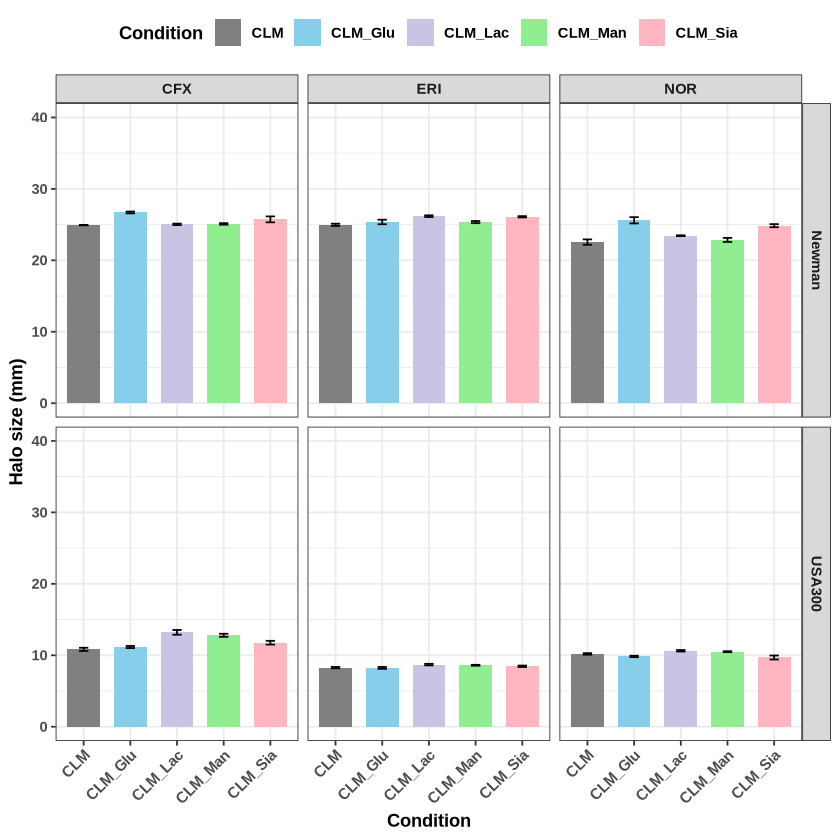

In [8]:
# Plot 
condition_colors <- c(
  "CLM" = "#808080",          # Gray
  "CLM_Glu" = "#87CEEB",      # Light Blue (SkyBlue)
  "CLM_Lac" = "#CBC3E3",  # Light purple
  "CLM_Sia" = "#FFB6C1",    # Light Pink
  "CLM_Man" = "#90EE90"    # Light green
)

antibiogram_plot <- ggplot(ab_data, aes(x = Condition, y = Mean, fill = Condition)) +
  geom_col(width = 0.7) +
  geom_errorbar(
    aes(ymin = Mean - SD_DV, ymax = Mean + SD_DV),
    width = 0.2
  ) +
  scale_fill_manual(values = condition_colors) +
  facet_grid(Isolate ~ Antibiotic, scales = "free_y") +
  ylab("Halo size (mm)") +
  xlab("Condition") +
  coord_cartesian(ylim = c(0, 40)) +  # Fix y-axis limits globally to 0-40
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, face = "bold"),
    axis.text.y = element_text(face = "bold"),
    axis.title.x = element_text(face = "bold"),
    axis.title.y = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
    legend.text = element_text(face = "bold"),
    strip.text = element_text(face = "bold"),  # facet labels
    plot.title = element_text(face = "bold"),
    legend.position = "top"
  )

antibiogram_plot

In [35]:
ggsave("antibiogram_pannel.png", antibiogram_plot, width = 10, height = 10, dpi = 300)

In [14]:
# Run Kruskal-Wallis test for each isolate
kw_results <- ab_long %>%
  group_by(Isolate, Antibiotic) %>%
  summarise(
    kw_test = list(kruskal.test(Value ~ Condition)),
    .groups = "drop"
  ) %>%
  mutate(
    statistic = sapply(kw_test, function(x) x$statistic),
    p_value = sapply(kw_test, function(x) x$p.value)
  ) %>%
  select(Isolate, Antibiotic, statistic, p_value)

kw_results

Isolate,Antibiotic,statistic,p_value
<chr>,<chr>,<dbl>,<dbl>
Newman,CFX,12.73107,0.01266742
Newman,ERI,11.47883,0.02167832
Newman,NOR,12.76667,0.01247401
USA300,CFX,13.23333,0.01019021
USA300,ERI,10.05257,0.03955142
USA300,NOR,12.43333,0.01440365


In [17]:
# Ad-hoc test 
dunn_results <- ab_long %>%
  group_by(Isolate, Antibiotic) %>%
  group_modify(~ {
    res <- dunnTest(Value ~ Condition, data = .x, method = "bonferroni")$res
    res <- as.data.frame(res)
    # Add significance stars column
    res <- res %>%
      mutate(signif = case_when(
        P.adj < 0.001 ~ "***",
        P.adj < 0.01 ~ "**",
        P.adj < 0.05 ~ "*",
        TRUE ~ ""
      ))
    res
  }) %>%
  ungroup()

dunn_results

Warning message:
“Condition was coerced to a factor.”
Warning message:
“Condition was coerced to a factor.”
Warning message:
“Condition was coerced to a factor.”
Warning message:
“Condition was coerced to a factor.”
Warning message:
“Condition was coerced to a factor.”
Warning message:
“Condition was coerced to a factor.”


Isolate,Antibiotic,Comparison,Z,P.unadj,P.adj,signif
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
Newman,CFX,CLM - CLM_Glu,-3.24358915,0.001180339,0.01180339,*
Newman,CFX,CLM - CLM_Lac,-1.00505579,0.314869984,1.00000000,
Newman,CFX,CLM_Glu - CLM_Lac,2.23853336,0.025186294,0.25186294,
Newman,CFX,CLM - CLM_Man,-1.32484627,0.185222143,1.00000000,
Newman,CFX,CLM_Glu - CLM_Man,1.91874288,0.055016882,0.55016882,
Newman,CFX,CLM_Lac - CLM_Man,-0.31979048,0.749127165,1.00000000,
Newman,CFX,CLM - CLM_Sia,-2.42127078,0.015466352,0.15466352,
Newman,CFX,CLM_Glu - CLM_Sia,0.82231838,0.410895720,1.00000000,
Newman,CFX,CLM_Lac - CLM_Sia,-1.41621498,0.156712570,1.00000000,


In [19]:
write.csv(dunn_results, "dunn_results.csv", row.names = FALSE)
write.csv(kw_results, "kw_results.csv", row.names = FALSE)